# Computing leaf tortuosity from segmented leaf microCT stacks
## Using the method in Earles et al. (to be submitted)

__Created__ on 2018-03-21 by Guillaume Théroux-Rancourt (guillaume.theroux-rancourt@boku.ac.at)

__Last edited__ on 2018-04-27 by Guillaume Théroux-Rancourt

Image processing note:
- The file used needs to have stomata either drawn on the segmented image (as is currently used) or on a separate image of the same dimensions as the segemented image (not implemented but easily done).
- __How I have drawn the stomata__: How I did label the stomata was in ImageJ, using both the grid and segmented stacks. I replaced both so to get a paradermal view, and then synchronized both windows (Analyze > Tools > Synchronize windows). When I saw a stoma, I labelled it at or immediately below start of the IAS at that point. For label, I just use an ellipsis, but any form would do. I saved that ROI into the ROI manager, and proceeded to the other stomata. When I labelled all at their right location, I filled all ROI with a specific color on the segmented stack in paradermal view ([using this macro](https://github.com/gtrancourt/imagej_macros/blob/master/macros/fillInside-macro.txt)). I then replaced it to the former view (i.e. in te same direction as to get the paradermal view).

Notes:
- This code works and the results are comparable to what would be done using the MorpholibJ plugin in ImageJ. However, the results are not identical, probably due to the different implementations of the geodesic distance computation.

To do:
- Clean up the import packages.
- Remove unused functions.
- Create a nicer output of the results.

Most recent updates:

__2018-04-27__
- Added stomata lbelling method in the preamble.
- Splitted cells here and there to separate some bits.
- Moved older updates to README.md

I've got help and inspiration from:
- https://stackoverflow.com/questions/28187867/geodesic-distance-transform-in-python
- https://stackoverflow.com/questions/47540926/get-the-largest-connected-component-of-segmentation-image


import skimage.io as io
from skimage import img_as_int, img_as_ubyte, img_as_float, feature, measure, color, morphology, filters
from skimage.util import invert
from skimage.measure import label
from skimage.transform import resize
import numpy as np
from scipy import ndimage, stats
from scipy.ndimage.morphology import distance_transform_edt
import skfmm
import time
import cv2
import random
from leaftortuosity import DisplayRndSlices, Threshold, Erosion3DimJ, getLargestAirspace

### Image Loading and Pre-processing

In [2]:
# Set path to tiff stacks
filepath = '/Users/gtrancourt/uCT/Drimys-winteri/'

# Read composite stack including slabelling of stomata
composite_stack = io.imread(filepath + 'Drimys-winteri-COMPOSITE-cropped-small-w-stomata.tif')
print(composite_stack.shape)
print(np.unique(composite_stack)) # to get all the unique values

DisplayRndSlices(composite_stack, 4)

In [4]:
# define pixel values
mesophyll = 0
ias = 255
bg = 152
veins = 170
stomata = 85

[False  True]
bool
bool


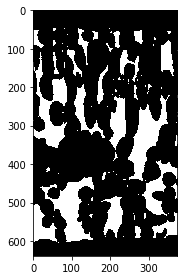

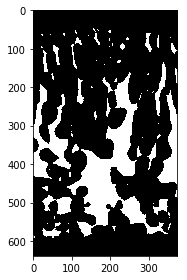

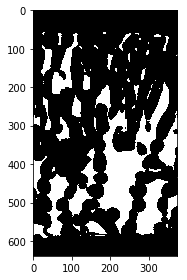

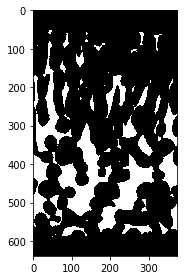

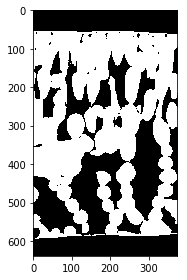

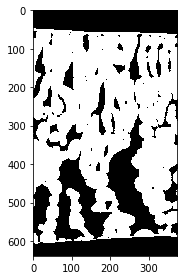

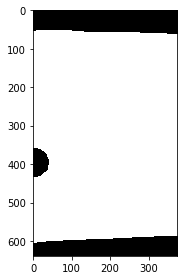

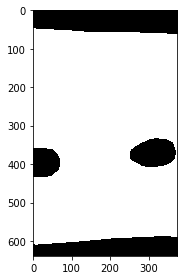

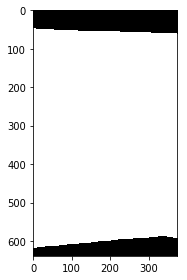

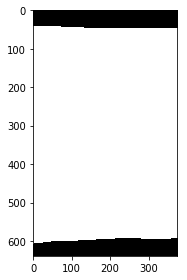

In [5]:
# Create the binary stacks needed for the analysis
mesophyll_wo_veins_stack = np.asarray(Threshold(composite_stack, [mesophyll,ias,stomata]), np.bool)
mesophyll_stack = np.asarray(Threshold(composite_stack, [mesophyll,veins,ias,stomata]), np.bool)
cell_stack_w_veins = np.asarray(Threshold(composite_stack, [mesophyll,veins]), np.bool)
airspace_stack = np.asarray(Threshold(composite_stack, ias), np.bool)
stomata_stack = np.asarray(Threshold(composite_stack, stomata), np.bool)
stomata_airspace_stack = np.asarray(Threshold(composite_stack, [stomata,ias]), np.bool)
print(np.unique(stomata_stack))
print(airspace_stack.dtype)
print(stomata_stack.dtype)

DisplayRndSlices(airspace_stack, 2)
DisplayRndSlices(stomata_airspace_stack, 2)
DisplayRndSlices(cell_stack_w_veins, 2)
DisplayRndSlices(mesophyll_wo_veins_stack, 2)
DisplayRndSlices(mesophyll_stack, 2)

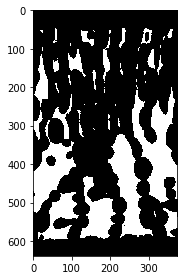

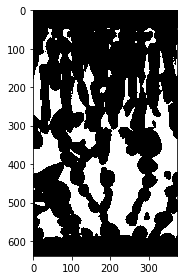

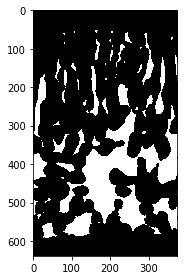

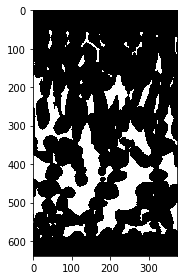

In [6]:
# Purify the airspace stack, i.e. get the largest connected component
largest_airspace = np.asarray(getLargestAirspace(airspace_stack), dtype='bool')
largest_airspace_w_stomata = np.asarray(getLargestAirspace(stomata_airspace_stack), dtype='bool')
DisplayRndSlices(largest_airspace, 2)
DisplayRndSlices(largest_airspace_w_stomata, 2)

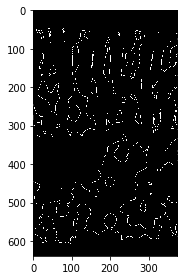

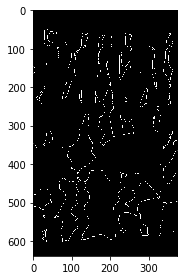

In [7]:
# Detect edges of airspace
# Better to work on largest airspace as this is what is needed further down.
airspace_outline_smaller = Erosion3DimJ(largest_airspace)
airspace_edge = invert(Threshold(largest_airspace - airspace_outline_smaller, 0))
DisplayRndSlices(airspace_edge, 2)
# io.imsave(filepath + '_airspace_edge.tif', img_as_ubyte(airspace_edge))


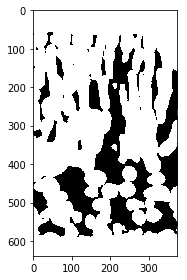

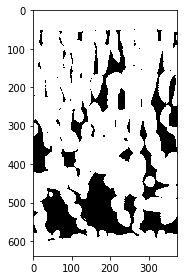

/Users/gtrancourt/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


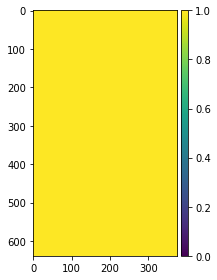

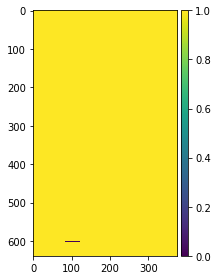

In [8]:
# Get the distance maps
mask = ~largest_airspace.astype(bool)

stom_mask = invert(np.asarray(stomata_stack, dtype='bool'))

DisplayRndSlices(mask, 2)
DisplayRndSlices(stom_mask, 2)

## Get the Euclidian distance from all stomata

L_euc processing time: 53.0 s


/Users/gtrancourt/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


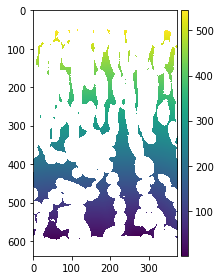

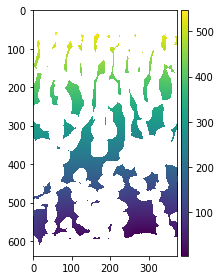

In [9]:
t0 = time.time()
L_euc = np.ma.masked_array(distance_transform_edt(stom_mask), mask)
t1 = time.time() - t0
print('L_euc processing time: '+str(np.round(t1))+' s')
DisplayRndSlices(L_euc, 2)

## Get the geodesic distance map

In the cell below, a purified/largest airspace stack needs to be used as an input as airspace unconnected to a stomata make the program run into an error (`ValueError: the array phi contains no zero contour (no zero level set)`). 

I initially ran into a error when trying to get a masked array to compute the distance map. The error I think was that stomata where often outside of the mask I was trying to impose, so an empty mask was produced. I solved that by creating an array with the stomata and the airspace together, and then creating the masked array of stomata position within the airspace+stomata stack.

__Note:__ The airspace should be assigned a value of 1, and the stomata a value of 0. Cells and background should be white or have no value assigned.

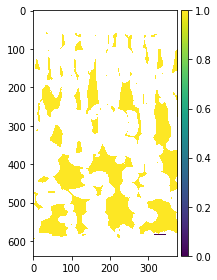

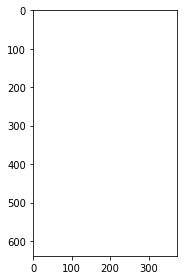

In [10]:
stomata_airspace_mask = ~stomata_airspace_stack.astype(bool)

largest_airspace_masked_array = np.ma.masked_array(stom_mask, stomata_airspace_mask)
DisplayRndSlices(largest_airspace_masked_array, 2)

In [11]:
t0 = time.time()
L_geo = skfmm.distance(largest_airspace_masked_array)
t1 = time.time() - t0
print('L_geo processing time: '+str(np.round(t1))+' s')

L_geo processing time: 111.0 s


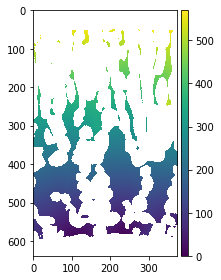

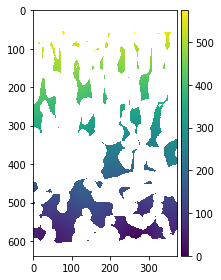

In [12]:
DisplayRndSlices(L_geo, 2)

## Compute the tortuosity factor

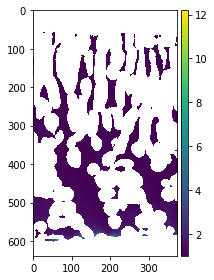

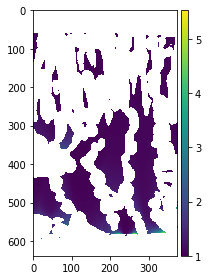

In [13]:
Tortuosity_Factor = np.square(L_geo / L_euc)
DisplayRndSlices(Tortuosity_Factor, 2)
# io.imsave(filepath + 'Python_tortuosity.tif', np.asarray(Tortuosity_Factor, dtype="float32"))

In [14]:
airspace_edge_bool = invert(~airspace_edge.astype(bool))

# Select only the values at the edge of the airspace
Tortuosity_at_mesophyll_surface = Tortuosity_Factor[airspace_edge_bool]

# Remove values below 1, if any, as tortuosity must be >= 1
Tortuosity_at_mesophyll_surface = Tortuosity_at_mesophyll_surface[Tortuosity_at_mesophyll_surface > 1]

print(np.median(Tortuosity_at_mesophyll_surface))
print(stats.describe(Tortuosity_at_mesophyll_surface))
print(np.mean(Tortuosity_at_mesophyll_surface))
print(np.std(Tortuosity_at_mesophyll_surface))
print(np.var(Tortuosity_at_mesophyll_surface))
print(np.shape(Tortuosity_at_mesophyll_surface))
print(np.min(Tortuosity_at_mesophyll_surface))
print(np.max(Tortuosity_at_mesophyll_surface))

/Users/gtrancourt/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


1.09732420153
DescribeResult(nobs=5110200, minmax=(1.0000000000000004, 187.25932511913186), mean=1.2749058690009785, variance=0.60718237675585107, skewness=26.092390991017844, kurtosis=2181.4295095673806)
1.274905869
0.779219005119
0.607182257938
(5110200,)
1.0
187.259325119


In [15]:
# To save
# io.imsave(filepath + 'Python_tortuosity.tif', np.asarray(Tortuosity_Factor * airspace_edge_bool, dtype="float32"))

In [16]:
# To save all the data point to a text file for later analysis
thefile = open(filepath + 'Tortuosity_at_mesophyll_surface.txt', 'w')
for item in Tortuosity_at_mesophyll_surface:
    thefile.write("%s\n" % item)


## Compute lateral diffusivity

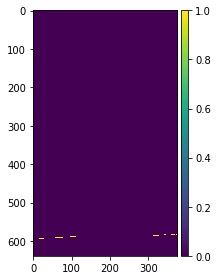

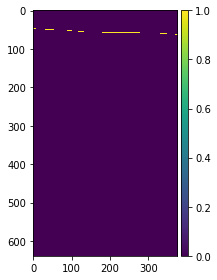

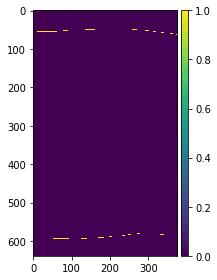

In [17]:
# Get the epidermal layer map
mesophyll_stack_shifted_up = np.roll(mesophyll_stack, -1, axis=1)
mesophyll_stack_shifted_down = np.roll(mesophyll_stack, 1, axis=1)
epidermis_edge_bottom = Threshold(invert(mesophyll_stack) + mesophyll_stack_shifted_up , 0)
epidermis_edge_top = Threshold(invert(mesophyll_stack) + mesophyll_stack_shifted_down , 0)
amphistomatous_epidermis = Threshold(epidermis_edge_bottom + epidermis_edge_top, 1)
DisplayRndSlices(epidermis_edge_bottom, 1)
DisplayRndSlices(epidermis_edge_top, 1)
DisplayRndSlices(amphistomatous_epidermis, 1)


L_epi processing time: 59.8 s


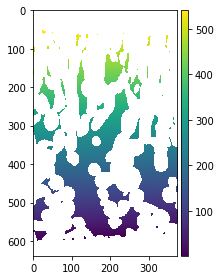

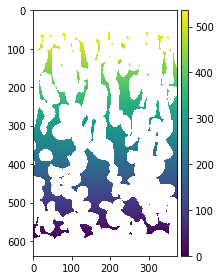

In [18]:
# Compute L_epi
epidermis_mask = invert(np.asarray(epidermis_edge_bottom, dtype='bool'))
# DisplayRndSlices(epidermis_mask, 2)

t0 = time.time()
L_epi = np.ma.masked_array(distance_transform_edt(epidermis_mask), mask)
t1 = time.time() - t0

print('L_epi processing time: '+str(np.round(t1, 1))+' s')
DisplayRndSlices(L_epi, 2)

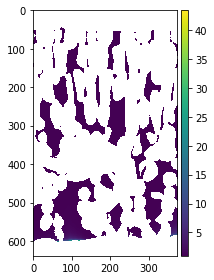

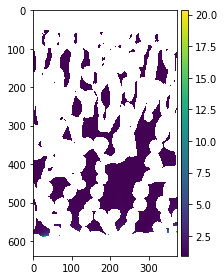

In [19]:
Lateral_diffusivity = (L_euc / L_epi) 
DisplayRndSlices(Lateral_diffusivity, 2)

In [20]:
Lateral_diffusivity_at_airspace_edge = Lateral_diffusivity[airspace_edge_bool]
# Lateral_diffusivity_at_airspace_edge = Lateral_diffusivity_at_airspace_edge[Lateral_diffusivity_at_airspace_edge > 1]
print(np.median(Lateral_diffusivity_at_airspace_edge))
print(stats.describe(Lateral_diffusivity_at_airspace_edge))
print(np.nanmean(Lateral_diffusivity_at_airspace_edge))
print(np.nanstd(Lateral_diffusivity_at_airspace_edge))
print(np.nanvar(Lateral_diffusivity_at_airspace_edge))
print(np.shape(Lateral_diffusivity_at_airspace_edge))
print(np.nanmin(Lateral_diffusivity_at_airspace_edge))
print(np.nanmax(Lateral_diffusivity_at_airspace_edge))

1.00864372677
DescribeResult(nobs=5119396, minmax=(0.1111111111111111, 101.84301645179212), mean=1.3320960097405499, variance=6.0483617163817485, skewness=16.8033073714634, kurtosis=370.2547050549556)
1.28204169627
1.95778935768
3.83293916904
(5119396,)
0.111111111111
101.843016452


In [21]:
## To save a stack of lateral diffusivity at the airspace edge
# Lateral_diffusivity_img = Lateral_diffusivity
# Lateral_diffusivity_img[airspace_edge_bool == 0] = 0
# io.imsave(filepath + 'Python_lateral_diffusivity-3.tif', np.asarray(Lateral_diffusivity_img, dtype="float32"))

In [22]:
# To save a txt file will all the data points
thefile = open(filepath + 'Lateral_diffusivity_at_airspace_edge.txt', 'w')
for item in Lateral_diffusivity_at_airspace_edge:
    thefile.write("%s\n" % item)

[0.9939170748890388 0.9937439499275534 1.008235455642433 ..., -- -- --]
